In [1]:
import sys
import torch
import warnings
import torchvision
import numpy as np
import torch.nn as nn
import torch.utils.data
import torch.optim as optim
import torchvision.utils as vutils
import torchvision.transforms as transforms

from scipy.stats import entropy
from torch.autograd import Variable
from torch.nn import functional as F
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader
from torchvision.models.inception import inception_v3

warnings.filterwarnings('ignore')
np.set_printoptions(threshold=sys.maxsize)

In [2]:
batch_size = 128
image_size = 64
nc = 3
nz = 100
ngf = 64
ndf = 64
num_epochs = 30
lrG = 0.0001
lrD = 0.0004
beta1 = 0.5
ngpu = 1

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

data = torchvision.datasets.CIFAR10(root='./data', download=True, transform=transform)
dataloader = DataLoader(data, batch_size=batch_size, shuffle=True)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'sheep', 'truck')

for (images, labels) in dataloader:
    print(images.shape)
    print(labels)
    break

100%|██████████| 170498071/170498071 [00:03<00:00, 48534353.31it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
torch.Size([128, 3, 64, 64])
tensor([5, 3, 8, 0, 7, 5, 4, 2, 6, 5, 6, 0, 8, 5, 2, 7, 0, 9, 4, 2, 3, 7, 8, 2,
        4, 3, 2, 7, 9, 9, 5, 7, 7, 6, 3, 1, 2, 4, 0, 0, 5, 3, 6, 7, 8, 4, 8, 2,
        7, 0, 3, 8, 5, 9, 9, 6, 9, 3, 7, 0, 2, 9, 4, 6, 5, 2, 8, 9, 6, 5, 5, 9,
        8, 0, 7, 2, 0, 5, 9, 2, 8, 3, 8, 1, 7, 9, 2, 9, 4, 3, 5, 3, 9, 8, 7, 9,
        8, 8, 0, 1, 6, 1, 4, 3, 7, 0, 6, 8, 1, 4, 1, 8, 2, 0, 8, 4, 3, 0, 2, 3,
        9, 9, 0, 0, 8, 8, 0, 3])


In [4]:
# Generator Code
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            nn.ConvTranspose2d(nz, ngf*8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf*8),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf*8, ngf*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf*4),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(ngf*4, ngf*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf*2),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf*2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)

In [5]:
# Discriminator code
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf, ndf*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf*2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf*2, ndf*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf*4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf*4, ndf*8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf*8),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(ndf*8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [6]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [8]:
netG = Generator(ngpu).to(device)
netG.apply(weights_init)

netD = Discriminator(ngpu).to(device)
netD.apply(weights_init)

criterion = nn.BCELoss()
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

real_label = 1.
fake_label = 0.

optimizerD = optim.Adam(netD.parameters(), lr=lrD, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lrG, betas=(beta1, 0.999))

G_losses = []
D_losses = []

print("Starting Training Loop...")
for epoch in range(num_epochs):
    for i, data in enumerate(dataloader, 0):
        # Train discriminator
        netD.zero_grad()
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)

        # using real data
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        output = netD(real_cpu).view(-1)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        # using fake data
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        fake = netG(noise)
        label.fill_(fake_label)
        output = netD(fake.detach()).view(-1)
        errD_fake = criterion(output, label)
        errD_fake.backward()
        errD = errD_real + errD_fake
        optimizerD.step()

        # Train generator
        netG.zero_grad()
        label.fill_(real_label)
        output = netD(fake).view(-1)
        errG = criterion(output, label)
        errG.backward()
        optimizerG.step()

    G_losses.append(errG.item())
    D_losses.append(errD.item())
    print('Epoch: {}/{} G Loss: {:.4f} D Loss: {:.4f}'.format(1+epoch, num_epochs, errG.item(), errD.item()))

Starting Training Loop...
Epoch: 1/30 G Loss: 7.9278 D Loss: 0.1188
Epoch: 2/30 G Loss: 2.0595 D Loss: 0.5288
Epoch: 3/30 G Loss: 3.8547 D Loss: 0.3017
Epoch: 4/30 G Loss: 6.0573 D Loss: 0.2960
Epoch: 5/30 G Loss: 2.9355 D Loss: 0.4751
Epoch: 6/30 G Loss: 4.6964 D Loss: 0.6838
Epoch: 7/30 G Loss: 3.9352 D Loss: 0.2169
Epoch: 8/30 G Loss: 4.0111 D Loss: 0.7264
Epoch: 9/30 G Loss: 3.2459 D Loss: 0.4300
Epoch: 10/30 G Loss: 4.2737 D Loss: 0.3149
Epoch: 11/30 G Loss: 4.5180 D Loss: 0.2530
Epoch: 12/30 G Loss: 0.6636 D Loss: 0.9076
Epoch: 13/30 G Loss: 3.9011 D Loss: 0.9185
Epoch: 14/30 G Loss: 3.9645 D Loss: 0.2305
Epoch: 15/30 G Loss: 7.2221 D Loss: 2.5624
Epoch: 16/30 G Loss: 1.5036 D Loss: 0.6664
Epoch: 17/30 G Loss: 1.4954 D Loss: 0.6224
Epoch: 18/30 G Loss: 0.0887 D Loss: 2.7604
Epoch: 19/30 G Loss: 1.7018 D Loss: 0.5171
Epoch: 20/30 G Loss: 4.9643 D Loss: 0.0619
Epoch: 21/30 G Loss: 0.4558 D Loss: 2.4385
Epoch: 22/30 G Loss: 5.9462 D Loss: 0.0414
Epoch: 23/30 G Loss: 4.9539 D Loss: 0

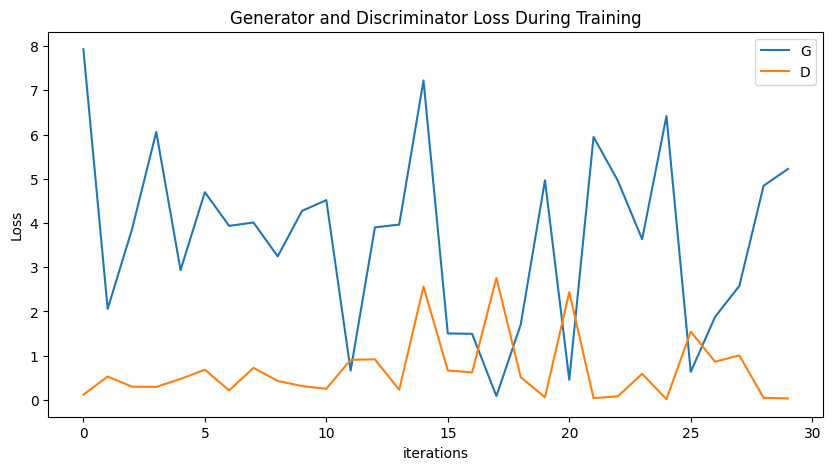

In [9]:
# Plot of Loss vs Epoch curve
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

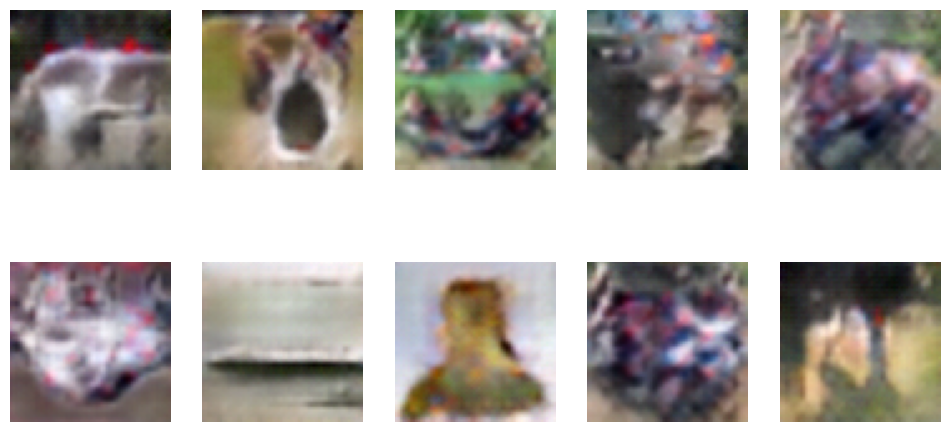

In [29]:
# Generate images from the learned distribution
netG.eval()

num = 10
images = []
with torch.no_grad():
    for i in range(num):
        noise = torch.randn(1, nz, 1, 1, device=device)
        image = netG(noise).detach().cpu()
        images.append(image.squeeze(1))
        vutils.save_image(image, f'image_{i+1}.png', normalize=True)

fig, axes = plt.subplots(2, 5, figsize=(12, 6))
for i in range(num):
    img = plt.imread(f"image_{i+1}.png")
    axes[i // 5, i % 5].imshow(img)
    axes[i // 5, i % 5].axis('off')
plt.show()

In [30]:
# Inception score of the generated images
def inception_score(imgs, cuda=True, batch_size=10, resize=False, splits=1):
    N = len(imgs)

    assert batch_size > 0
    assert N == batch_size

    # Set up dtype
    if cuda:
        dtype = torch.cuda.FloatTensor
    else:
        dtype = torch.FloatTensor

    imgs_tensor = torch.cat(imgs, dim=0).type(dtype)
    dataloader = torch.utils.data.DataLoader(imgs_tensor, batch_size=batch_size)

    # Load Inception v3 model
    inception_model = inception_v3(pretrained=True, transform_input=False).type(dtype)
    inception_model.eval()
    up = nn.Upsample(size=(299, 299), mode='bilinear').type(dtype)

    def get_pred(x):
        if resize:
            x = up(x)
        x = inception_model(x)
        return F.softmax(x, dim=1).data.cpu().numpy()

    # Get predictions
    preds = np.zeros((N, 1000))

    for i, batch in enumerate(dataloader, 0):
        batchv = Variable(batch)

        preds[i * batch_size:i * batch_size + batch_size] = get_pred(batchv)

    # compute the mean kl-div
    split_scores = []

    for k in range(splits):
        part = preds[k * (N // splits): (k + 1) * (N // splits), :]
        py = np.mean(part, axis=0)
        scores = []
        for i in range(part.shape[0]):
            pyx = part[i, :]
            scores.append(entropy(pyx, py))
        split_scores.append(np.exp(np.mean(scores)))

    return np.mean(split_scores), np.std(split_scores)

print("Calculating Inception Score...")
print(inception_score(images, cuda=True, batch_size=10, resize=True, splits=1))

Calculating Inception Score...
(3.03765330867862, 0.0)
